# 对CompetitionRecord实现聚类

### 环境准备

##### 常用环境导入

In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE

In [2]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

##### 连接数据库

In [127]:
import sqlite3
conn = sqlite3.connect("../db.sqlite3")
cur = conn.cursor()
table_name = cur.execute("select name from sqlite_master where type='table' order by name").fetchall()
table_name

In [125]:
cur.execute("PRAGMA table_info(account_profile_competitionrecord)")
cur.fetchall()

[(0, 'id', 'integer', 1, None, 1),
 (1, 'name', 'varchar(256)', 1, None, 0),
 (2, 'holder', 'varchar(256)', 1, None, 0),
 (3, 'awardName', 'varchar(25)', 1, None, 0),
 (4, 'competeRange', 'varchar(2)', 1, None, 0),
 (5, 'awardLevel', 'varchar(1)', 1, None, 0),
 (6, 'otherAward', 'varchar(256)', 0, None, 0),
 (7, 'teammateAmount', 'integer', 1, None, 0),
 (8, 'selfOrder', 'integer', 1, None, 0),
 (9, 'certificateID', 'varchar(256)', 0, None, 0),
 (10, 'certificateDistributeOrganizationName', 'varchar(256)', 0, None, 0),
 (11, 'type', 'varchar(2)', 1, None, 0),
 (12, 'SchoolYear_id', 'integer', 1, None, 0),
 (13, 'User_id', 'integer', 1, None, 0)]

### 构建CSV

##### all_type

In [8]:
csv_head = ["id", "User_id", "competeRange", "awardLevel", "type"]
record = conn.execute(("select {} from account_profile_competitionrecord").
                            format(",".join(csv_head))).fetchall()

##### research_award_only

In [114]:
csv_head = ["id", "User_id", "competeRange", "awardLevel"]
record = conn.execute(("select {} from account_profile_competitionrecord where type == 'ra'").
                            format(",".join(csv_head))).fetchall()

##### competition_award_only

In [159]:
csv_head = ["id", "User_id", "competeRange", "awardLevel"]
record = conn.execute(("select {} from account_profile_competitionrecord where type == 'ia'").
                            format(",".join(csv_head))).fetchall()

In [115]:
import csv

def save_csv(record, csv_head, csv_name):
    with open(csv_name, "w", newline="") as f:
        ff = csv.writer(f)
        ff.writerow(csv_head)
        ff.writerows(record)

In [63]:
def read_record(csv_name, csv_head):
    df_record = pd.read_csv(csv_name, header=0, encoding="utf-8")
    mapping = list(map(lambda x:False if x <= 1 else True, [i for i in range(0, len(csv_head))]))
#     df_one_hot = pd.factorize(df_record.loc[:, mapping].copy())
    df_fact = df_record.loc[:, mapping].copy()
    df_one_hot = pd.get_dummies(df_record.loc[:, mapping].copy())
    return df_record, df_one_hot, df_fact

list(map(lambda x:False if x <= 1 else True, [i for i in range(0, len(csv_head))]))

##### research_only

In [84]:
save_csv(record, csv_head, "competition_record_research_award.csv")

##### competition_only

In [173]:
save_csv(record, csv_head, "competition_record_competition_record.csv")

### 读取data_frame

##### research_award

In [204]:
df_record, df_record_one_hot, df_record_fact = read_record("competition_record_research_award.csv", csv_head)

##### competition_record

In [214]:
df_record, df_record_one_hot, df_record_fact = read_record("competition_record_competition_record.csv", csv_head)

show columns

In [211]:
df_record_fact.columns

Index(['competeRange', 'awardLevel'], dtype='object')

##### Factorize或Mapping给record赋值 

##### factorize

In [56]:
for i in df_record_fact.columns:
    df_record_fact[i] = pd.Series(pd.factorize(df_record_fact[i])[0])

##### mapping

In [215]:
compete_mapping = {
    'in': 1,
    'na': 2,
    'ds': 3,
    'lr': 4,
    'cl': 5,
    'ot': 6
}

award_mapping = {
    'u': 1,
    'f': 2,
    's': 3,
    't': 4,
    'r': 5,
    'o': 6
}

type_mapping = {
    'ra': 1,
    'ia': 2
}

df_record_fact['competeRange'] = df_record_fact['competeRange'].map(compete_mapping)
df_record_fact['awardLevel'] = df_record_fact['awardLevel'].map(award_mapping)
# df_record_fact['type'] = df_record_fact['type'].map(type_mapping)

### TSNE/PCA 可视化

##### TSNE 可视化

##### one-hot

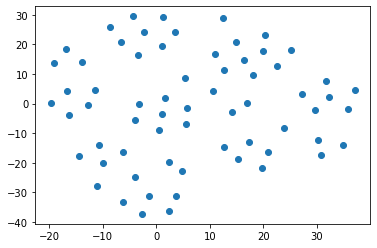

In [177]:
projection = TSNE().fit_transform(df_record_one_hot)
plt.scatter(*projection.T)

##### factorize

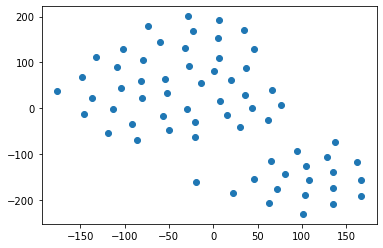

In [178]:
projection = TSNE().fit_transform(df_record_fact)
plt.scatter(*projection.T)

##### PCA 可视化

one-hot

Text(0, 0.5, 'cumulative explained variance')

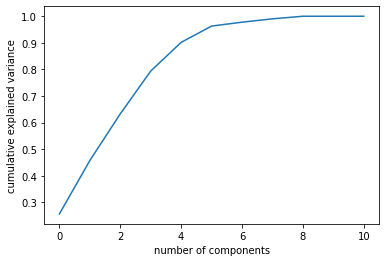

In [179]:
pca = PCA().fit(df_record_one_hot)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [167]:
# factorize

Text(0, 0.5, 'cumulative explained variance')

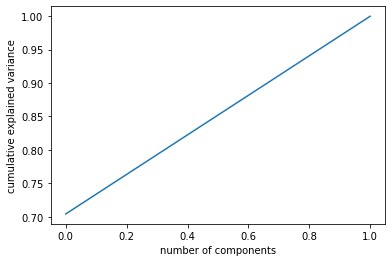

In [180]:
pca = PCA().fit(df_record_fact)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

### Kmeans

#### Kmeans多簇比较

In [181]:
def score_kmeans(data_set):
    scores_sil = []
    scores_cal = []
    for i in range(2, 10):
        km = KMeans(n_clusters=i)
        km.fit(data_set)
        scores_sil.append(silhouette_score(data_set, km.labels_))
        scores_cal.append(calinski_harabasz_score(data_set, km.labels_))
    return scores_sil, scores_cal

##### one-hot

In [182]:
scores_one_hot_sil, scores_one_hot_cal = score_kmeans(df_record_one_hot)

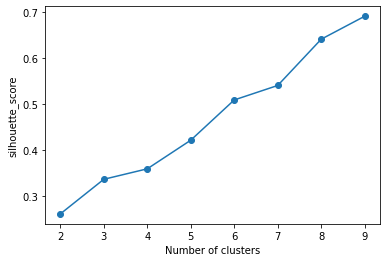

In [183]:
plt.plot(range(2,10), scores_one_hot_sil, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette_score')
plt.savefig("Paper_kmeans_sc_one_h.png")
plt.show()

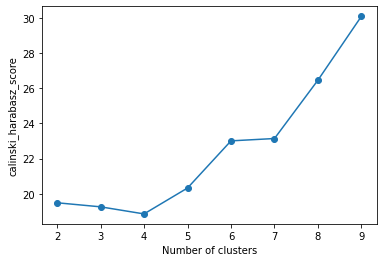

In [184]:
plt.plot(range(2,10), scores_one_hot_cal, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('calinski_harabasz_score')
plt.savefig("Paper_kmeans_cc_one_h.png")
plt.show()

很奇怪上面这个究竟怎么定聚类个数比较合适，或者应该将科技获奖和竞赛创新分开聚类// 可能后面的思想值得一试

##### factorize

In [185]:
scores_fact_sil, scores_fact_cal = score_kmeans(df_record_fact)

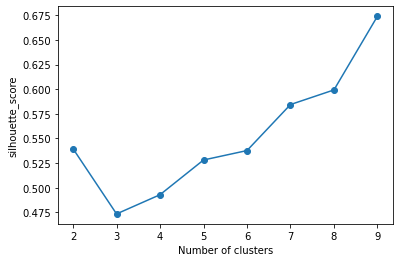

In [186]:
plt.plot(range(2,10), scores_fact_sil, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette_score')
plt.savefig("Paper_kmeans_sc_fac.png")
plt.show()

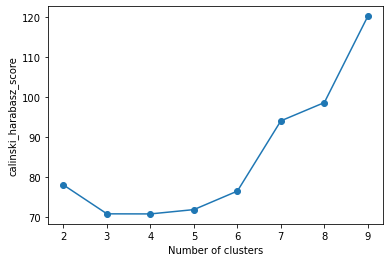

In [187]:
plt.plot(range(2,10), scores_fact_cal, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('calinski_harabasz_score')
plt.savefig("Paper_kmeans_cc_fac.png")
plt.show()

这让我怎么聚类???

嗯，确实应该按照research和 competition分开聚类更合适，research的聚类个数应该为8

### Spectral Clustering

In [188]:
from sklearn.cluster import SpectralClustering

In [189]:
def score_spectral(data_set):
    scores_sil = []
    scores_cal = []
    x_labels = []
    for index, gamma in enumerate((0.01,0.1,1,10)):
        for index, k in enumerate((3,4,5,6,7)):
            y_pred = SpectralClustering(n_clusters=k, gamma=gamma).fit_predict(data_set)
            scores_sil.append(silhouette_score(data_set, y_pred))
            scores_cal.append(calinski_harabasz_score(data_set, y_pred))
            x_labels.append(str(k) + "-" + str(gamma))
    return scores_sil, scores_cal, x_labels

##### one-hot

In [190]:
score_one_hot_sil, score_one_hot_cal, x_labels = score_spectral(df_record_one_hot)

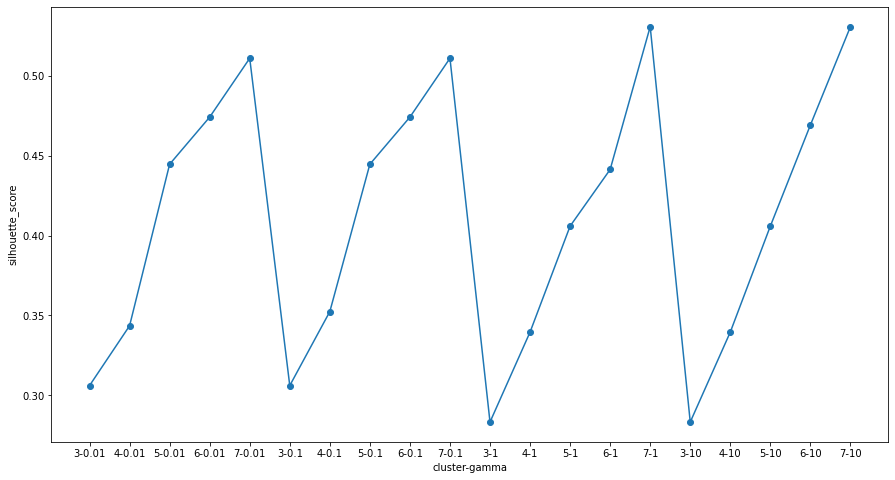

In [191]:
plt.figure(figsize=(15, 8))
plt.plot(x_labels, score_one_hot_sil, marker='o')
plt.xlabel('cluster-gamma')
plt.ylabel('silhouette_score')
plt.savefig("Paper_spectralClustering_sc_one_h.png")
plt.show()

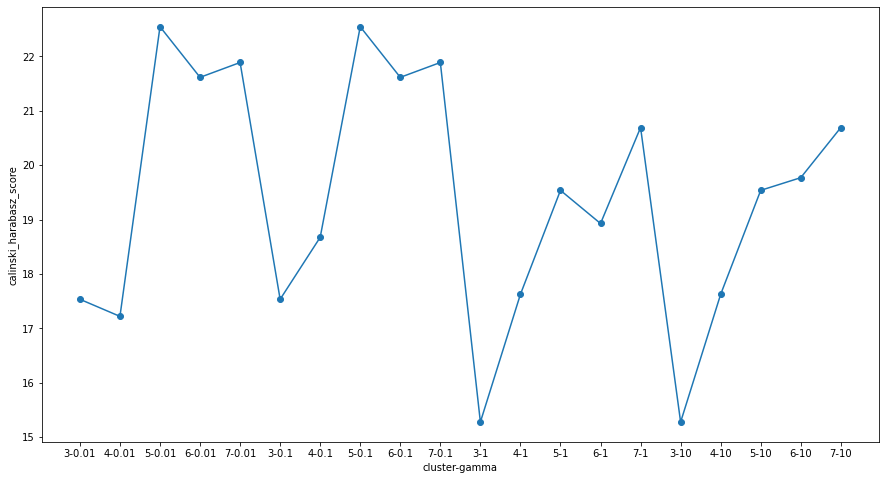

In [192]:
plt.figure(figsize=(15, 8))
plt.plot(x_labels, score_one_hot_cal, marker='o')
plt.xlabel('cluster-gamma')
plt.ylabel('calinski_harabasz_score')
plt.savefig("Paper_spectralClustering_ca_one_h.png")
plt.show()

##### factorize

In [193]:
score_one_hot_sil, score_one_hot_cal, x_labels = score_spectral(df_record_fact)

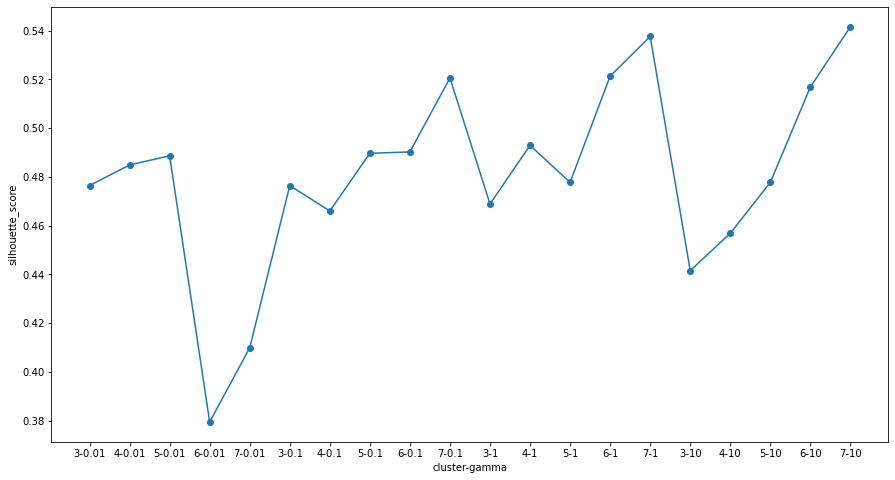

In [194]:
plt.figure(figsize=(15, 8))
plt.plot(x_labels, score_one_hot_sil, marker='o')
plt.xlabel('cluster-gamma')
plt.ylabel('silhouette_score')
plt.savefig("Paper_spectralClustering_sc_one_h.png")
plt.show()

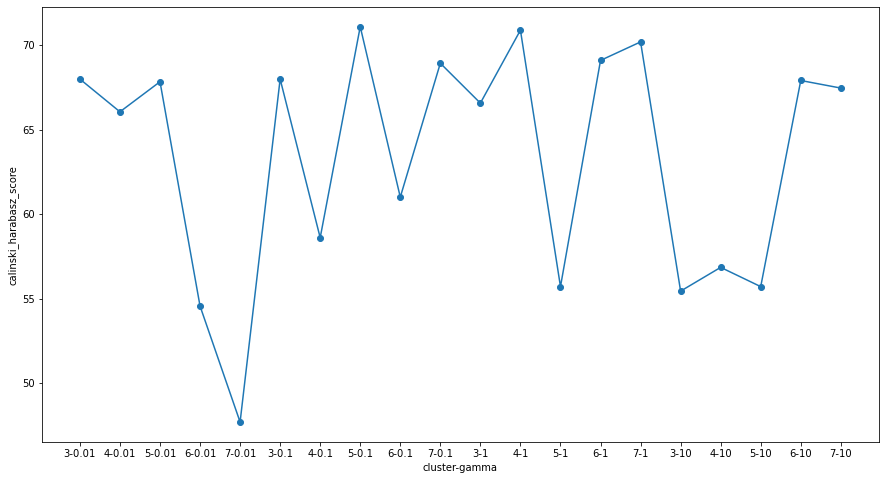

In [195]:
plt.figure(figsize=(15, 8))
plt.plot(x_labels, score_one_hot_cal, marker='o')
plt.xlabel('cluster-gamma')
plt.ylabel('calinski_harabasz_score')
plt.savefig("Paper_spectralClustering_ca_one_h.png")
plt.show()

### 保存聚类CSV

#### Spectral Clustering

In [196]:
def spectral_clustering(num_clusters, gamma, data_set, data_set_origin, save_name):
    sc = SpectralClustering(n_clusters=num_clusters, gamma=gamma).fit(data_set)
    result = sc.labels_
    data_set['labels'] = result
    data_set.groupby('labels')['labels'].count().plot(kind='bar')
    data_set['user_id'] = data_set_origin.loc[:, ['User_id']]
    data_set = data_set.sort_values("user_id").reset_index(drop=True)
    data_set.to_csv("{}_spectral.csv".format(save_name))

##### one-hot

research_only: num_clustering = 7, gamma = 1

competition_only: num_clustering = 7, gamma = 0.1

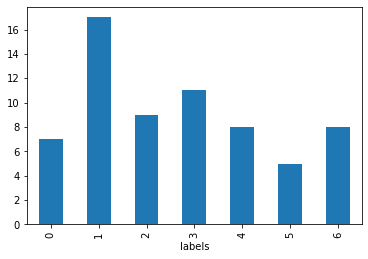

In [202]:
spectral_clustering(7, 0.1, df_record_one_hot, df_record, "competition_one_hot")

##### factorize

research_only: num_clustering = 7, gamma = 1

competition_only: num_clustering = 7, gamma = 1

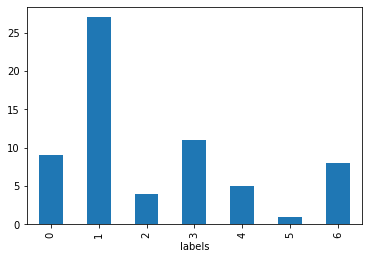

In [213]:
spectral_clustering(7, 1, df_record_fact, df_record, "competition_fact")

#### kmeans

In [150]:
def kmeans(num_clusters, data_set, data_set_origin, save_name):
    kmeans = KMeans(n_clusters=num_clusters, random_state=10).fit(data_set)
    result = kmeans.labels_
    data_set['labels'] = result
    data_set.groupby('labels')['labels'].count().plot(kind='bar')
    data_set['user_id'] = data_set_origin.loc[:, ['User_id']]
    data_set = data_set.sort_values("user_id").reset_index(drop=True)
    data_set.to_csv("{}_kmeans.csv".format(save_name))

##### one-hot

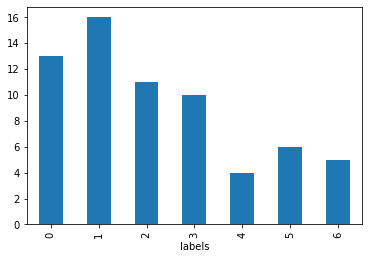

In [216]:
kmeans(7, df_record_one_hot, df_record, "competition_one_hot")

##### factorize

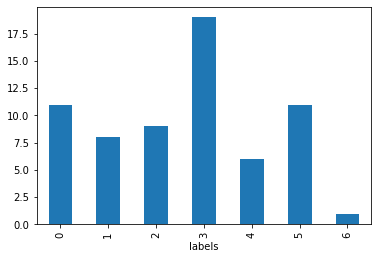

In [217]:
kmeans(7, df_record_fact, df_record, "competition_fact")